# Data Visualization of Molecular libraries 

### Exploratory Data Analysis to evaluate the molecular libraries
- Violin plots comparing molecular properties among molecular libraries.
- Dimensionality reduction analysis (PCA and t-SNE) to visualize the distribution of the molecules according to the molecular descriptors computed in the [previous notebook](./3_Comparing_Molecules_among_Molecular_Libraries.ipynb).
- Cluster heat maps showing the Tanimoto similarity among the active molecules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Import the dataframe with no duplicated molecules
input_file = './df_MOLECULES_no_duplicates.obj'
df_mols = pd.read_pickle(input_file)
# Change Activity column
df_mols.Activity = df_mols.Activity.replace({1: 'active', 0: 'decoy'})

df_mols.head()

,library,Lig,Activity,mol_rdk,sanitized,MW,num_atoms,num_rot,num_rings,charge
0,COCRYS,STU,active,<rdkit.Chem.rdchem.Mol object at 0x7fa68bf7d670>,True,465.533,35,2,8,1
1,COCRYS,ATP,active,<rdkit.Chem.rdchem.Mol object at 0x7fa68cb61fb0>,True,503.150,31,8,3,-4
2,COCRYS,PVB,active,<rdkit.Chem.rdchem.Mol object at 0x7fa68cb0d5f0>,True,259.700,18,2,3,0
3,COCRYS,DTQ,active,<rdkit.Chem.rdchem.Mol object at 0x7fa68cb0d630>,True,297.314,22,4,3,0
4,COCRYS,HMD,active,<rdkit.Chem.rdchem.Mol object at 0x7fa68cb0d670>,False,323.130,19,0,3,0


How many actives are there in each molecular library?

In [3]:
display(df_mols\
            .groupby('library')['Activity']\
            .value_counts()
       )

library  Activity
COCRYS   active       289
CSAR     decoy         85
         active        26
DEKOIS2  decoy       1198
         active        38
DUD      decoy       1790
         active        62
Name: Activity, dtype: int64

## Data visualization

In [4]:
sns.set(style = 'white', context = 'notebook', font_scale = 1.4)

In [5]:
def plot_by_prop(df_in, column, ylabel = '', 
                 title = 'Molecular Mass (Da) - Actives/Decoys'):
    '''A simple function to generate violinplots 
       given a molecular property'''
    df = df_in.copy()
    df['Activity'] = df['Activity']\
                     .replace({1: 'active', 0: 'decoy'})
    fig, ax = plt.subplots(figsize = (10, 5))
    sns.violinplot(data = df,
                   x = 'library', y = column,
                   hue = 'Activity', bw=.15,
                   palette = ['#ED8D81', '#FAD585'],
                   inner = "quartile",
                   split = True, ax = ax)
    ax.grid()
    ax.legend(bbox_to_anchor = (1.01, 1),
              loc = 'upper left', title = 'Activity')
    ax.set(xlabel = 'Molecular library', 
           ylabel = ylabel, title = title)
    plt.show()

### Molecular Weight

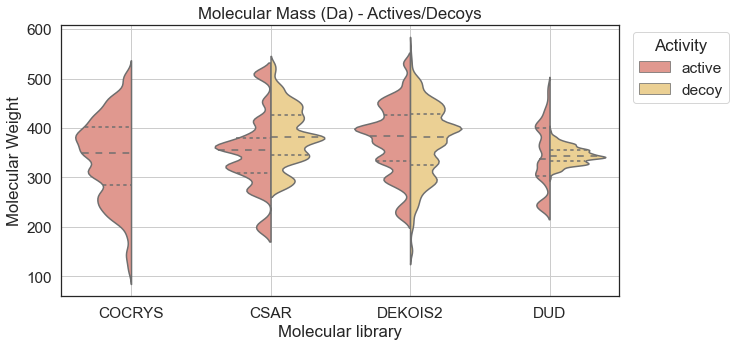

In [6]:
plot_by_prop(df_mols, column = 'MW', ylabel = 'Molecular Weight')

### Number of Heavy Atoms

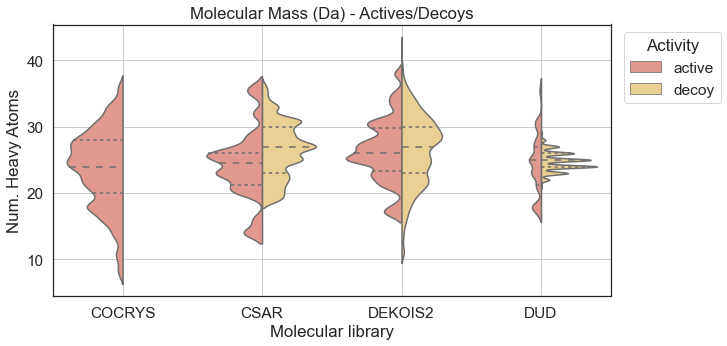

In [7]:
plot_by_prop(df_mols, column = 'num_atoms', ylabel = 'Num. Heavy Atoms')

### Net charge

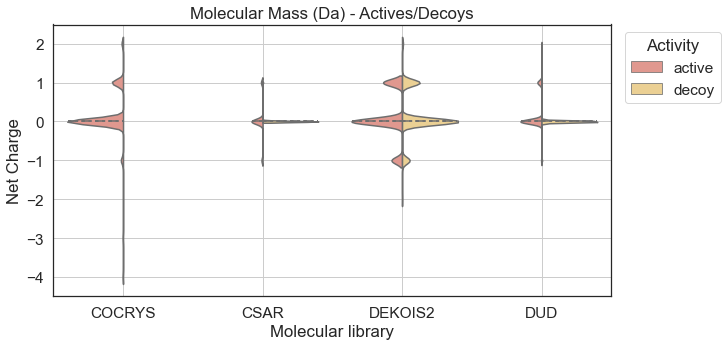

In [8]:
plot_by_prop(df_mols, column = 'charge', ylabel = 'Net Charge')

### Number of rings

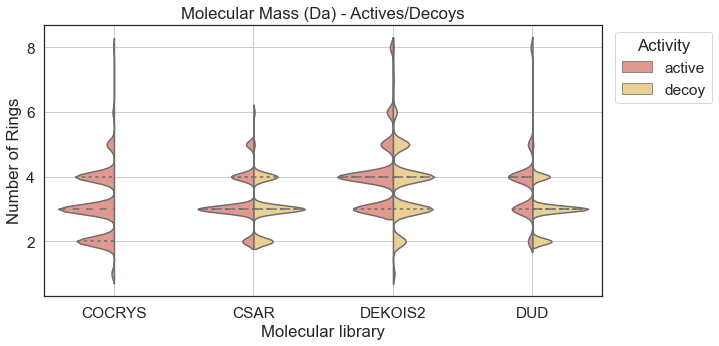

In [9]:
plot_by_prop(df_mols, column = 'num_rings', ylabel = 'Number of Rings')

## Load Molecular Descriptors
These descriptors were computed in the previous notebook.

In [10]:
# Save molecular fingerprints in a single object
fps_file = './rdkit_fingerprints_all_libraries_no_duplicates.obj'

with open(fps_file, 'rb') as f:
    all_fps = joblib.load(filename = f)

## Dimensionality Reduction

### Principal Component Analysis

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def do_pca(X_set, **kwargs):
    pca = PCA(**kwargs)
    pca_dims = pca.fit_transform(X_set)
    return pca_dims

def do_tsne(X_set, pca_args = {}, **tsne_args):
    ''' A simple function to comput tSNE'''
    X_decomp = do_pca(X_set, **pca_args)
    tsne = TSNE(**tsne_args)
    tsne_dims = tsne.fit_transform(X_decomp)
    dim_1 = tsne_dims[:, 0]
    dim_2 = tsne_dims[:, 1]
    return (dim_1, dim_2)

In [12]:
# Compute the projections for each set of descriptors
projections_pca = {key: 
                   do_pca(X_set = values, 
                          n_components = 2
                         ).reshape((2, -1))
                   for key, values in all_fps.items()}

# Add the two dimensions to the main dataframe
df_rdims = df_mols.copy()
for key, values in projections_pca.items():
    df_rdims[f'{key}_pca_x'] = values[0]
    df_rdims[f'{key}_pca_y'] = values[1]

### t-SNE

In [13]:
# Compute the projections for each set of descriptors
projections_tsne = {key: 
                   do_tsne(X_set = values, 
                           n_components = 2,
                           pca_args = {'n_components': n_c}
                          )
                   for (key, values), n_c in zip(all_fps.items(), 
                                               [30, 30, 30, 5])}

# Add the two dimensions to the main dataframe
# df_rdims = df_mols.copy()
for key, values in projections_tsne.items():
    df_rdims[f'{key}_tsne_x'] = values[0]
    df_rdims[f'{key}_tsne_y'] = values[1]

### Plot using Bokeh

In [14]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import column, row
from bokeh.transform import factor_cmap, factor_mark
output_notebook()

Loading BokehJS ...

In [15]:
%run ../../helper_modules/plot_with_bokeh.py

In [16]:
# Create the columndatasources
source_act   = ColumnDataSource(
                data = df_rdims.query('Activity == "active"')\
                       .drop('mol_rdk', axis=1))

source_inact = ColumnDataSource(
                data = df_rdims.query('Activity == "decoy"')\
                       .drop('mol_rdk', axis=1))

# Create the color and marker mappers
LIBRARIES = np.unique(source_act.data['library'])
ACTIVITY = np.unique(source_act.data['Activity'])
# Color mappers
col_library_map = factor_cmap('library', 
                              ['#20C55A', '#FF5733', 
                               'orange', '#857CEA'], 
                              LIBRARIES)

#### Plot PCA projections

In [17]:
kind_rd = 'pca'
plots_pca = {desc_set: create_fig_bokeh(desc = desc_set, 
                              source_act = source_act, 
                              source_inact = source_inact, 
                              kind_dr = kind_rd,
                              col_library_map = col_library_map, 
                              title = f'PCA: {desc_set}', 
                              legend=True)
             for desc_set in projections_pca.keys()
            }

plots  = list(plots_pca.values()) 
layout = column(row(*plots[0:2]), 
                row(*plots[2:4]))

show(layout)

#### Plot t-SNE projections

In [18]:
kind_rd = 'tsne'
plots_tsne = {desc_set: create_fig_bokeh(desc = desc_set, 
                              source_act = source_act, 
                              source_inact = source_inact, 
                              kind_dr = kind_rd,
                              col_library_map = col_library_map, 
                              title = f't-SNE: {desc_set}', 
                              legend = True)
             for desc_set in projections_tsne.keys()
            }

plots  = list(plots_tsne.values()) 
layout = column(row(*plots[0:2]), 
                row(*plots[2:4]))

show(layout)

## Tanimoto Clustermaps using Active molecules

In [19]:
actives_filter = df_mols.Activity == 'active'
df_actives     = df_mols[actives_filter]

In [20]:
%%time
from scipy.spatial.distance import pdist, squareform

# Function to compute the similarity and distance matrix
def get_distance_mtx(df, dist='jaccard'):
    dist_mtx = squareform( pdist(df, dist))
    return dist_mtx

def get_similarity_mtx(df, dist='jaccard'):
    dist_mtx = get_distance_mtx(df, dist)
    sim_mtx = 1 - dist_mtx
    return sim_mtx

#****************************
# Compute similarity matrices
#****************************

# MACCS
df = all_fps['MACCS'][actives_filter]
siml_mtx_maccs = get_similarity_mtx(df, dist='jaccard') 

# Morgan 
df = all_fps['Morgan'][actives_filter]
siml_mtx_morgan = get_similarity_mtx(df, dist='jaccard')  

# RDKit 
df = all_fps['RDKFps'][actives_filter]
siml_mtx_rdk = get_similarity_mtx(df, dist='jaccard')  

# Physicochemical properties 
df = all_fps['Phys'][actives_filter]
siml_mtx_rdk = get_similarity_mtx(df, dist='jaccard')  

CPU times: user 374 ms, sys: 23.7 ms, total: 398 ms
Wall time: 432 ms


In [21]:
from matplotlib import gridspec

# Activity side bars Colors
library_colors = ['green' if i == 'COCRYS' 
                  else 'orange' if i == 'DEKOIS2'
                  else 'purple' if i == 'DUD' 
                  else 'red' for i in df_actives.library]


def plot_cluster_map(mtx, 
                     title, 
                     col_cluster = False, 
                     row_cluster = False, 
                     figsize = (6, 5),
                     col_colors = library_colors, 
                     row_colors = library_colors,
                     cbar_pos = (1, 0.3, 0.03, 0.5), 
                     dendrogram_ratio= (0.01, 0.01),
                     **kwargs):
    ''' A function to plot Similarity Heatmap of a given set of molecules'''
    clusmap = sns.clustermap(mtx, cmap = 'YlGnBu',
                        col_cluster = col_cluster, row_cluster = row_cluster,
                        col_colors = library_colors, row_colors = library_colors,
                        cbar_pos = cbar_pos, dendrogram_ratio = dendrogram_ratio,
                        cbar_kws={'label': 'Tanimoto Similarity'},
                        figsize = figsize, **kwargs)
    clusmap.fig.suptitle(title, y = 1.01, fontweight = 'bold')
    return clusmap

#### Similarity Heatmaps between Active molecules among all libraries

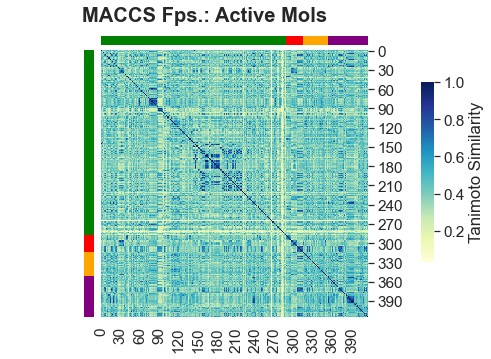

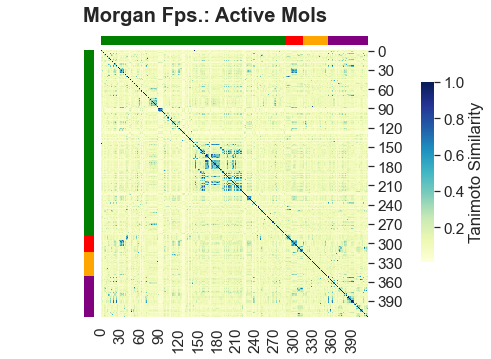

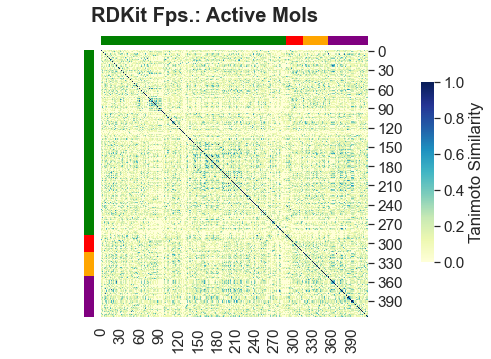

In [22]:
clusmap_maccs  = plot_cluster_map(siml_mtx_maccs, title  = 'MACCS Fps.: Active Mols',
                                 dendrogram_ratio=(0.2, 0.01))
clusmap_morgan = plot_cluster_map(siml_mtx_morgan, title = 'Morgan Fps.: Active Mols',
                                 dendrogram_ratio=(0.2, 0.01))
clusmap_rdk    = plot_cluster_map(siml_mtx_rdk, title = 'RDKit Fps.: Active Mols',
                                 dendrogram_ratio=(0.2, 0.01))
plt.show()

#### Similarity Cluster between Active molecules among all libraries

/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


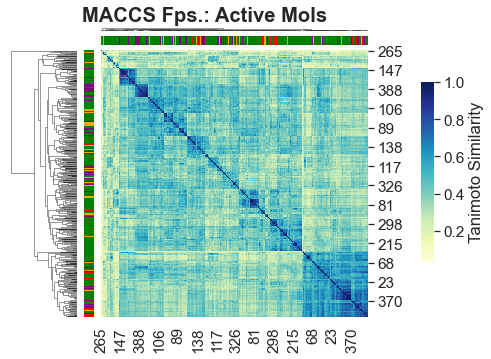

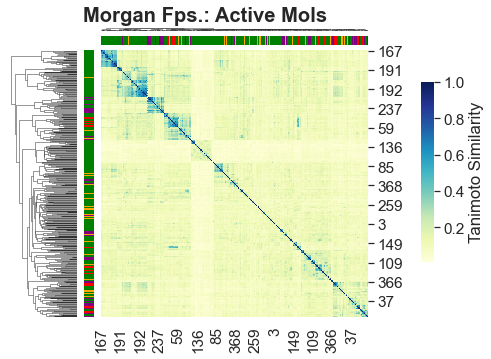

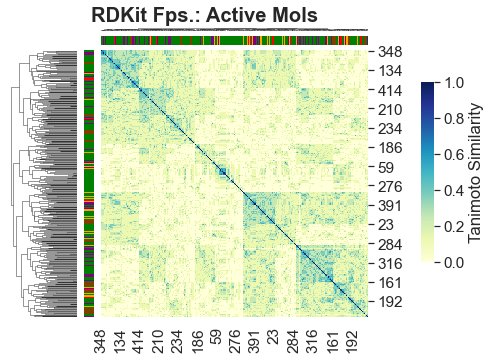

In [23]:
clusmap_maccs  = plot_cluster_map(siml_mtx_maccs, title  = 'MACCS Fps.: Active Mols',
                                 col_cluster=True, row_cluster=True, 
                                 dendrogram_ratio=(0.2, 0.01))
clusmap_morgan = plot_cluster_map(siml_mtx_morgan, title = 'Morgan Fps.: Active Mols',
                                 col_cluster=True, row_cluster=True, 
                                 dendrogram_ratio=(0.2, 0.01))
clusmap_rdk    = plot_cluster_map(siml_mtx_rdk, title = 'RDKit Fps.: Active Mols',
                                 col_cluster=True, row_cluster=True, 
                                 dendrogram_ratio=(0.2, 0.01))
plt.show()